### Data Combination and Filtering

Output `full_non_transit_radar` inside filtered_data folder. 

Comprehensive labels of radar detections (predicted as non-transit of confidence score >= 0.5) and tagged detections labelled as non-transit manually combined.

Currently have 3043 rows

#### Manual Assignment Logic

* If activity == loster/seine/trawl, assign type_agg = fishing_boat for tagged tracks
* For radar tracks: infer on activity based on type might be a bit problematic ...



In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import sys
import os

sys.path.append(os.path.abspath('..'))

#detections data
radar_detections = pd.read_csv('../../data/cleaned_data/preprocessed_radar_detections.csv')
tagged_detections = pd.read_csv('../../data/raw_data/detections_tagged.csv')

#label data
activity_labels_from_tagged = pd.read_csv('../../data/labels/activity_labels_from_tagged.csv')
inferred_activity_label = pd.read_csv('../../data/labels/radar_activity_labels_inferred.csv')
ais_type_labels = pd.read_csv('../../data/labels/ais_type_labels.csv')

In [52]:
#Deemed as transit if confidence score >= 0.5
transit_inferred = inferred_activity_label[inferred_activity_label['activity_inferred'] == 'transit']
transit_inferred = transit_inferred[transit_inferred['activity_confidence_score'] >= 0.5]
non_transit_inferred = inferred_activity_label[~inferred_activity_label['id_track'].isin(transit_inferred['id_track'])]

print(f'Total number of transit tracks: {len(transit_inferred)}')
print(f'Total number of non-transit tracks: {len(non_transit_inferred)}')


Total number of transit tracks: 12885
Total number of non-transit tracks: 1319


In [53]:
#full non-transit radar labels
filtered_radar_labels = pd.merge(ais_type_labels, non_transit_inferred, on='id_track', how='inner')
filtered_radar_labels.drop_duplicates(subset=['id_track'], inplace=True)

In [54]:
non_transit_tagged = activity_labels_from_tagged[activity_labels_from_tagged['activity'] != 'transit']

In [55]:
full_non_transit_labels = pd.concat([non_transit_tagged, filtered_radar_labels], ignore_index=True)
full_non_transit_labels

,id_track,activity,type_m2,activity_inferred,activity_confidence_score
0,30278317,drifting,NaN,NaN,NaN
1,31250348,hook,NaN,NaN,NaN
2,32095898,drifting,NaN,NaN,NaN
3,32096807,drifting,NaN,NaN,NaN
4,32099745,drifting,NaN,NaN,NaN
...,...,...,...,...,...
3038,36223372,NaN,passenger_ship,hook,0.997884
3039,37533419,NaN,pleasure_craft,stopped,0.999456
3040,38864791,NaN,pleasure_craft,lobster,0.960697
3041,37563158,NaN,pleasure_craft,stopped,0.999275


In [56]:
from core.DICT import TYPES2AGG

full_non_transit_labels['type_agg'] = full_non_transit_labels['type_m2'].map(TYPES2AGG)
full_non_transit_labels['type_agg'].value_counts()


type_agg
class_b           590
other             334
passenger_ship    222
tug/tow           102
cargo/tanker       31
military_ship      22
fishing_boat       18
Name: count, dtype: int64

In [57]:
#infer on type_agg based on activity
full_non_transit_labels.loc[
    (full_non_transit_labels['activity'] == 'lobster') |
    (full_non_transit_labels['activity'] == 'seine') |
    (full_non_transit_labels['activity'] == 'trawl'),
    'type_agg'
] = 'fishing_boat'


In [58]:
TYPES2AGG

{'tanker_ship': 'cargo/tanker',
 'cargo_ship': 'cargo/tanker',
 'tug': 'tug/tow',
 'towing_ship': 'tug/tow',
 'fishing_boat': 'fishing_boat',
 'commercial_fishing_boat': 'fishing_boat',
 'military_ship': 'military_ship',
 'class_b': 'class_b',
 'passenger_ship': 'passenger_ship',
 'pleasure_craft': 'class_b',
 'sailboat': 'class_b',
 'search_and_rescue_boat': 'other',
 'pilot_boat': 'other',
 'high_speed_craft': 'other',
 'law_enforcement_boat': 'other',
 'other': 'other',
 'unknown': 'other'}

In [59]:
full_non_transit_labels['type_agg'].value_counts()

type_agg
class_b           590
other             334
fishing_boat      238
passenger_ship    222
tug/tow           102
cargo/tanker       31
military_ship      22
Name: count, dtype: int64

In [60]:
full_non_transit_labels.to_csv('../../data/filtered_data/full_non_transit_radar_labels.csv', index=False)

/Users/liuzehan/Desktop/Protected Seas/peter/core/track_plot.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])


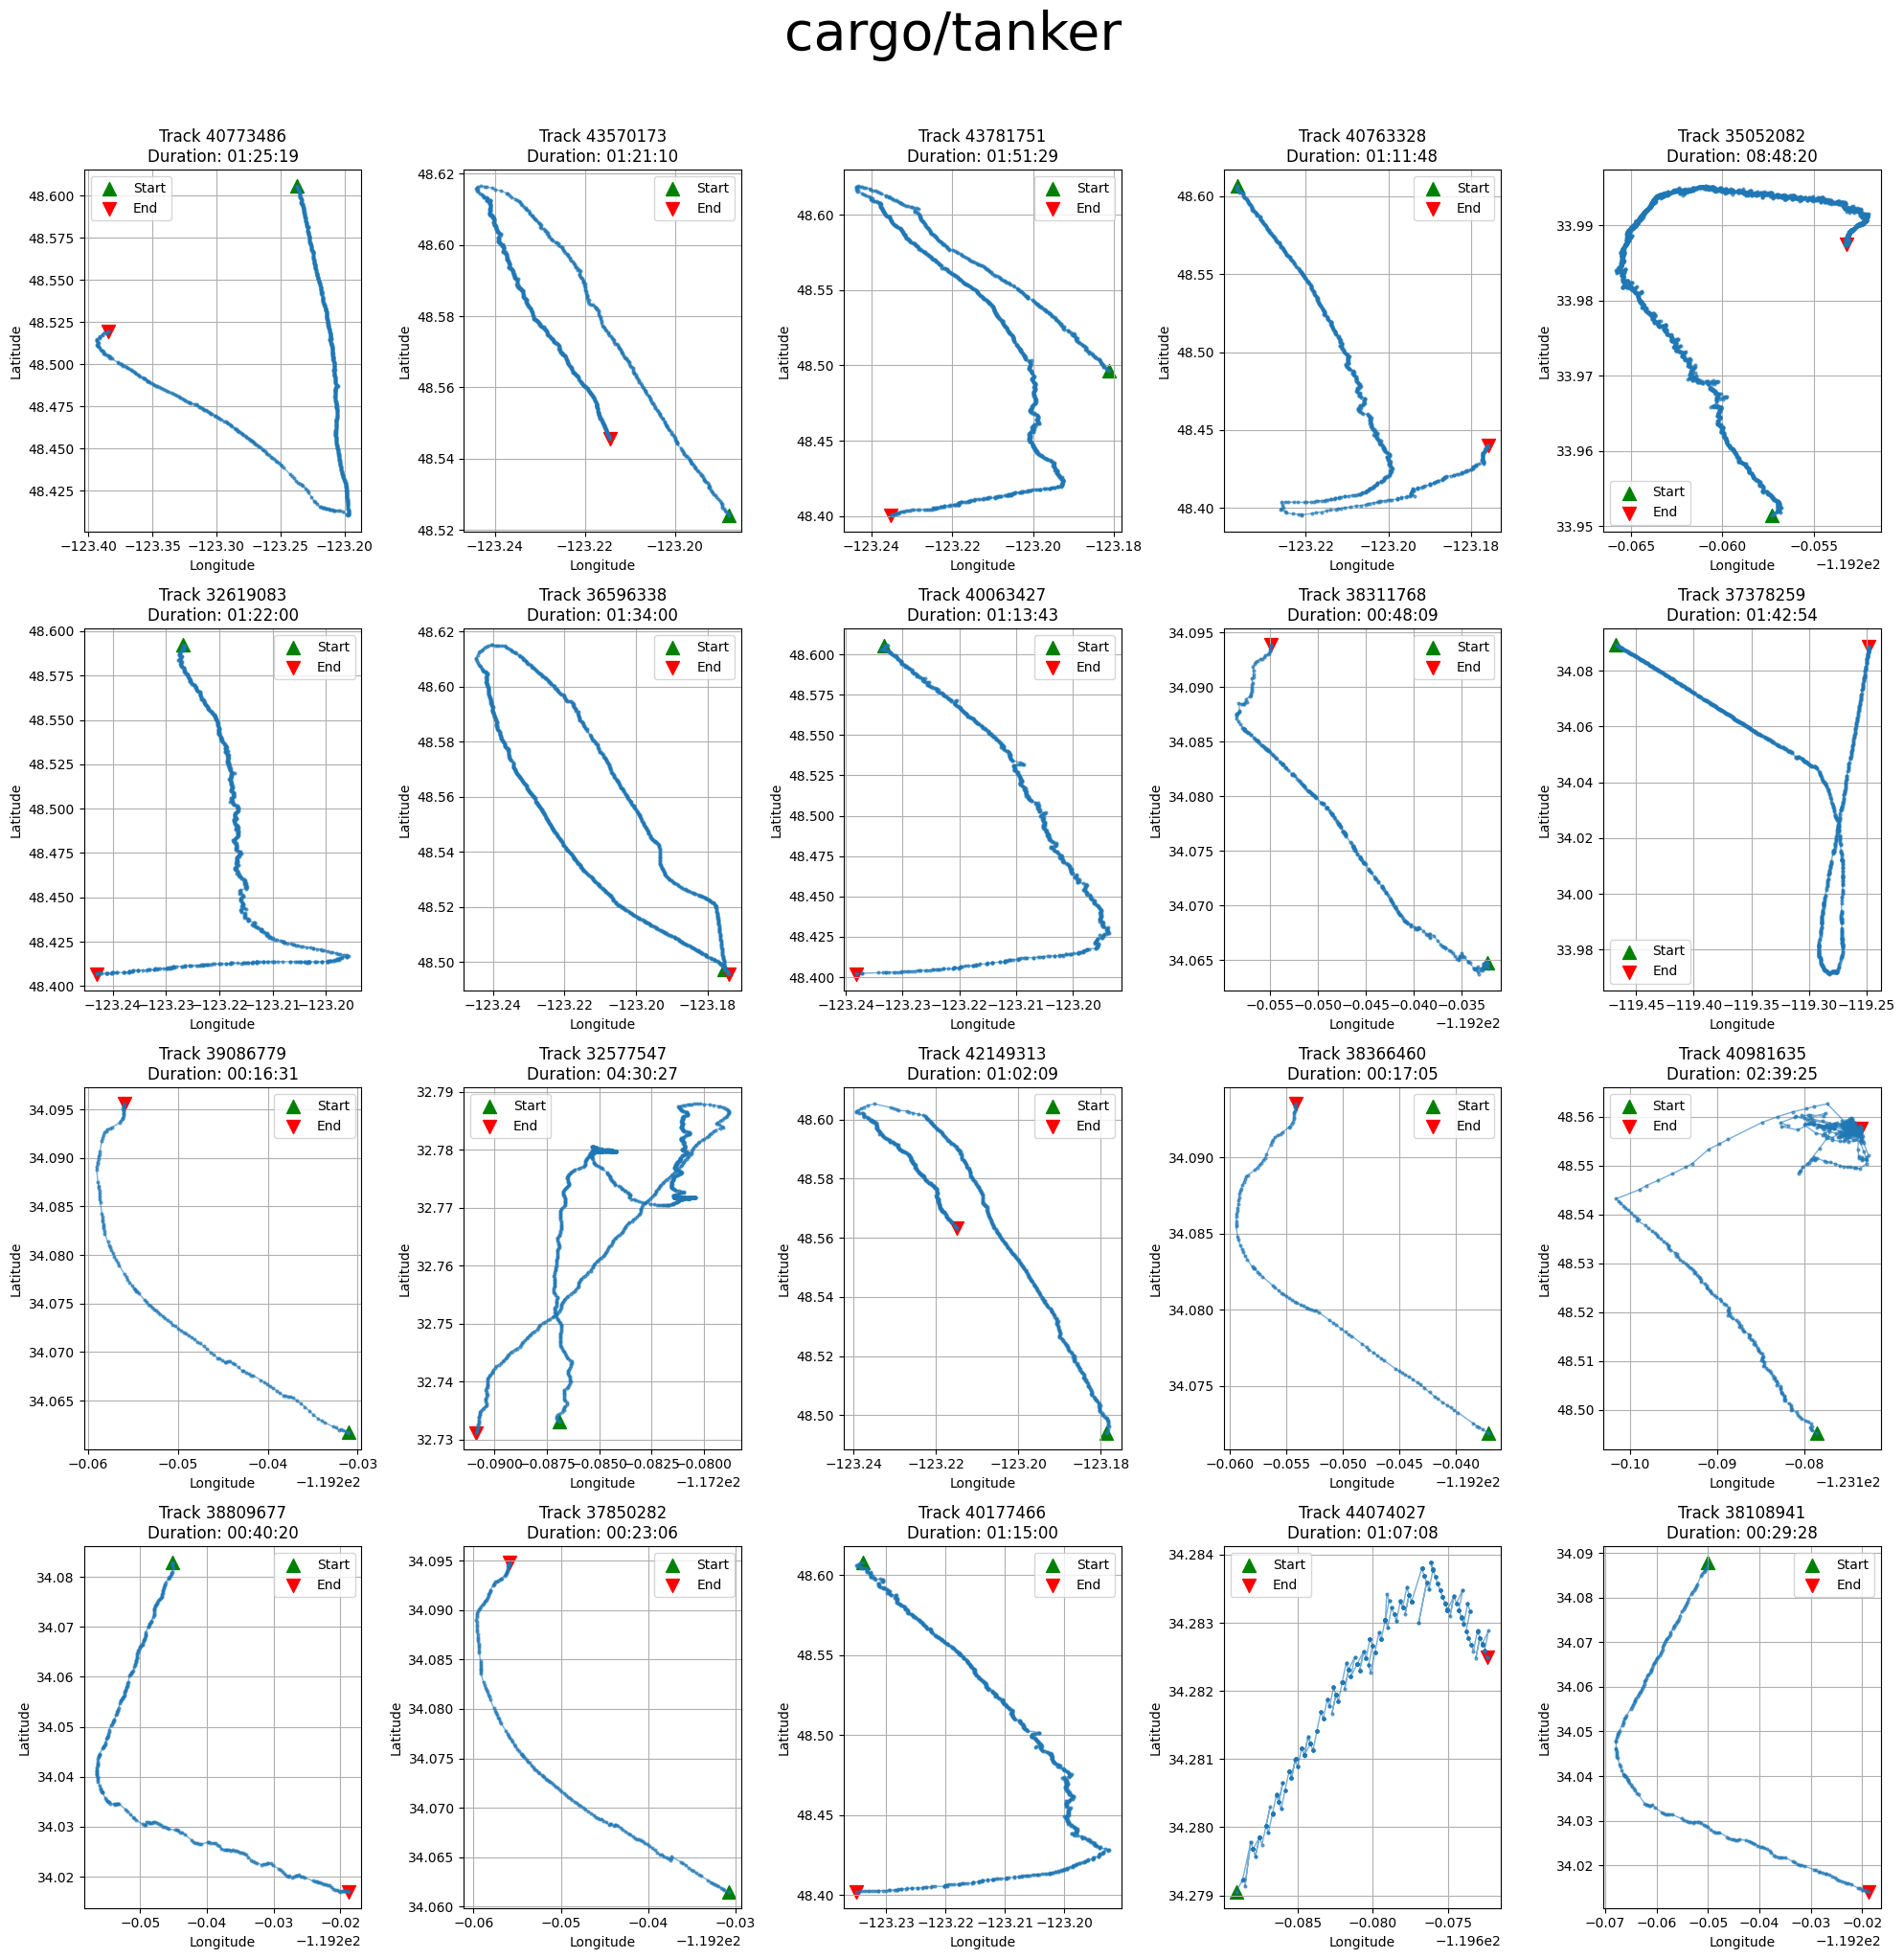

In [66]:
from core.track_plot import TrackPlot

full_detections = pd.concat([radar_detections, tagged_detections])

track_plot = TrackPlot(full_detections, full_non_transit_labels)
track_plot.plot_trajectory('type_agg', 'cargo/tanker', 20)


In [62]:
tagged_detections.head()

,id_detect,id_track,id_site,id_m2,source,speed,course,assoc_str,assoc_id,confidence,longitude,latitude,datetime
0,1315108673,29980760,10,18-0704-1000,radar,7.5,3.2,NaN,NaN,0.872091,-117.279102,32.798307,2023-07-04 10:00:12
1,1315108674,29980760,10,18-0704-1000,radar,11.3,349.5,NaN,NaN,0.872091,-117.279330,32.798868,2023-07-04 10:00:18
2,1315108675,29980760,10,18-0704-1000,radar,13.3,347.6,NaN,NaN,0.872091,-117.279482,32.799303,2023-07-04 10:00:24
3,1315108676,29980760,10,18-0704-1000,radar,13.6,351.3,NaN,NaN,0.872091,-117.279515,32.799792,2023-07-04 10:00:30
4,1315108677,29980760,10,18-0704-1000,radar,11.9,353.9,NaN,NaN,0.872091,-117.279520,32.800133,2023-07-04 10:00:37
